# IMPORT DEPENDENCIES

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# CREATING OUR DATA

In [4]:
x = np.linspace(0,50,501)
y = np.sin(x)

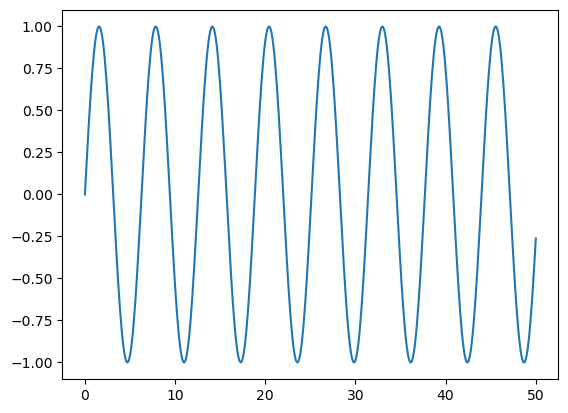

In [9]:
plt.plot(x,y)

### NOTE

#### For train data, initially we consider an interval, for example from 0:43
#### For test data, initially we consider an interval with the remaining points. 
#### Since we are testing a sin wave, which is a periodical function, we should have at least a full cicle (2pi) to check the forecasting
#### Then, we will feed as train data all the dataset and then try to predict the behaviour of the function (with a sin wave we know which is the behavior 
#### but not with a real world dataset

In [11]:
# Turning into a dataframe
df = pd.DataFrame(y, columns=['Sin'],index=x)

In [12]:
df

,Sin
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


# TRAIN TEST SPLIT
#### We will do it as said before

In [14]:
len(df)

501

In [15]:
# I counted almost 8 cicles

In [18]:
501/8

62.625

<Axes: >

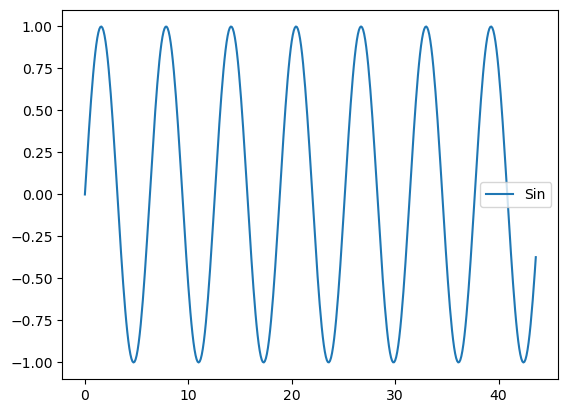

In [25]:
df.iloc[0:501-64].plot()

<Axes: >

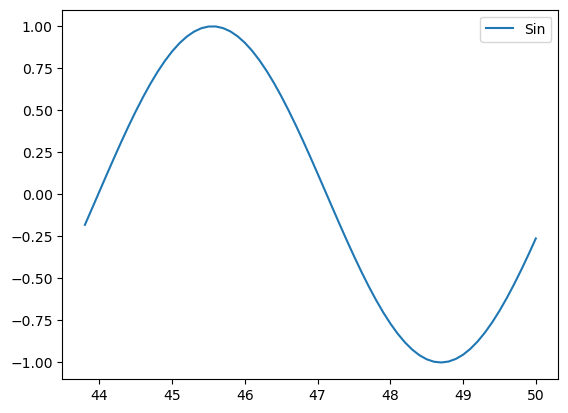

In [26]:
df.iloc[501-63:].plot()

### Lets consider - as train data from 0 to 501-64 - as test data the remaining ones
#### note: we could have used different approaches, such as defining a percentage (10%)

In [28]:
train = df.iloc[0:501-64]
test = df.iloc[501-64:]

# Scale data

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
scaler = MinMaxScaler()

In [31]:
scaler.fit(train)

MinMaxScaler()

In [32]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [33]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [35]:
# define generator
length = 2 # Length of the output sequences (in number of timesteps)
batch_size = 1 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [39]:
len(generator)

435

In [41]:
len(scaled_train)

437

In [42]:
# -2 bcs of the length

In [43]:
# What does the first batch look like?
X,y = generator[0]

In [46]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.49999912 0.54991622]
Predict this y: 
 [[0.59933458]]


In [51]:
generator[0]

(array([[[0.49999912],
         [0.54991622]]]),
 array([[0.59933458]]))

In [52]:
generator[1]

(array([[[0.54991622],
         [0.59933458]]]),
 array([[0.64776041]]))

In [53]:
generator[2]

(array([[[0.59933458],
         [0.64776041]]]),
 array([[0.69470985]]))

In [54]:
# basically, the formula in this case is: x[i]+x[i+1] -> x[i+2], for i in the interval

In [55]:
# for a better prediction, we should use more points

In [56]:
# Let's redefine to get 10 steps back and then predict the next step out
length = 10 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [57]:
generator[0]

(array([[[0.49999912],
         [0.54991622],
         [0.59933458],
         [0.64776041],
         [0.69470985],
         [0.73971381],
         [0.78232262],
         [0.82211054],
         [0.85868004],
         [0.89166571]]]),
 array([[0.92073798]]))

In [59]:
generator[1]

(array([[[0.54991622],
         [0.59933458],
         [0.64776041],
         [0.69470985],
         [0.73971381],
         [0.78232262],
         [0.82211054],
         [0.85868004],
         [0.89166571],
         [0.92073798]]]),
 array([[0.94560637]]))

In [60]:
length = 50 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

# MODEL

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN

In [62]:
# define the model
model = Sequential()

# We're only using one feature in our time series
n_features = 1

# Simple RNN layer
model.add(SimpleRNN(50,input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
model.fit(generator,epochs=5) # fit_generator

Epoch 1/5
387/387 [==============================] - 3s 8ms/step - loss: 2.9039e-04
Epoch 2/5
387/387 [==============================] - 3s 8ms/step - loss: 2.8816e-04
Epoch 3/5
387/387 [==============================] - 3s 8ms/step - loss: 2.7661e-05
Epoch 4/5
387/387 [==============================] - 2s 5ms/step - loss: 1.9508e-05
Epoch 5/5
387/387 [==============================] - 2s 5ms/step - loss: 3.9217e-04


In [65]:
model.history.history.keys()

dict_keys(['loss'])

<Axes: >

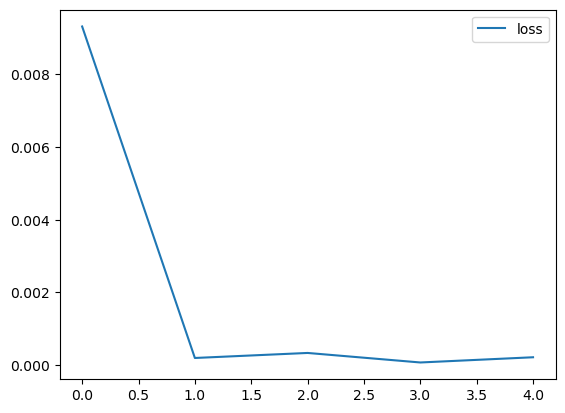

In [66]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [67]:
# seems ok

# Evaluate on test

In [70]:
first_eval_batch = scaled_train[-length:]

In [71]:
first_eval_batch

array([[9.20977757e-01],
       [9.45807630e-01],
       [9.66183132e-01],
       [9.81900676e-01],
       [9.92803220e-01],
       [9.98781828e-01],
       [9.99776764e-01],
       [9.95778087e-01],
       [9.86825751e-01],
       [9.73009203e-01],
       [9.54466495e-01],
       [9.31382900e-01],
       [9.03989060e-01],
       [8.72558686e-01],
       [8.37405820e-01],
       [7.98881698e-01],
       [7.57371240e-01],
       [7.13289205e-01],
       [6.67076045e-01],
       [6.19193508e-01],
       [5.70120021e-01],
       [5.20345908e-01],
       [4.70368497e-01],
       [4.20687145e-01],
       [3.71798252e-01],
       [3.24190300e-01],
       [2.78338972e-01],
       [2.34702398e-01],
       [1.93716581e-01],
       [1.55791039e-01],
       [1.21304709e-01],
       [9.06021693e-02],
       [6.39901882e-02],
       [4.17346643e-02],
       [2.40579672e-02],
       [1.11367167e-02],
       [3.10001778e-03],
       [2.81703720e-05],
       [1.95186738e-03],
       [8.85188786e-03],


In [72]:
# now I need to reshape to a shape the model expects
first_eval_batch = first_eval_batch.reshape((1,length,n_features))

In [73]:
first_eval_batch

array([[[9.20977757e-01],
        [9.45807630e-01],
        [9.66183132e-01],
        [9.81900676e-01],
        [9.92803220e-01],
        [9.98781828e-01],
        [9.99776764e-01],
        [9.95778087e-01],
        [9.86825751e-01],
        [9.73009203e-01],
        [9.54466495e-01],
        [9.31382900e-01],
        [9.03989060e-01],
        [8.72558686e-01],
        [8.37405820e-01],
        [7.98881698e-01],
        [7.57371240e-01],
        [7.13289205e-01],
        [6.67076045e-01],
        [6.19193508e-01],
        [5.70120021e-01],
        [5.20345908e-01],
        [4.70368497e-01],
        [4.20687145e-01],
        [3.71798252e-01],
        [3.24190300e-01],
        [2.78338972e-01],
        [2.34702398e-01],
        [1.93716581e-01],
        [1.55791039e-01],
        [1.21304709e-01],
        [9.06021693e-02],
        [6.39901882e-02],
        [4.17346643e-02],
        [2.40579672e-02],
        [1.11367167e-02],
        [3.10001778e-03],
        [2.81703720e-05],
        [1.9

In [74]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 319ms/step


array([[0.3547461]], dtype=float32)

In [75]:
# now we are predicting scaled versions now
# This one should be similar to the first point in scaled_test

In [76]:
scaled_test[0]

array([0.3607167])

In [77]:
np.abs(0.3547461 - 0.3607167)

0.005970599999999993

### Now we need to make this logic to everything (in a loop)

In [78]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

In [79]:
current_batch

array([[[9.20977757e-01],
        [9.45807630e-01],
        [9.66183132e-01],
        [9.81900676e-01],
        [9.92803220e-01],
        [9.98781828e-01],
        [9.99776764e-01],
        [9.95778087e-01],
        [9.86825751e-01],
        [9.73009203e-01],
        [9.54466495e-01],
        [9.31382900e-01],
        [9.03989060e-01],
        [8.72558686e-01],
        [8.37405820e-01],
        [7.98881698e-01],
        [7.57371240e-01],
        [7.13289205e-01],
        [6.67076045e-01],
        [6.19193508e-01],
        [5.70120021e-01],
        [5.20345908e-01],
        [4.70368497e-01],
        [4.20687145e-01],
        [3.71798252e-01],
        [3.24190300e-01],
        [2.78338972e-01],
        [2.34702398e-01],
        [1.93716581e-01],
        [1.55791039e-01],
        [1.21304709e-01],
        [9.06021693e-02],
        [6.39901882e-02],
        [4.17346643e-02],
        [2.40579672e-02],
        [1.11367167e-02],
        [3.10001778e-03],
        [2.81703720e-05],
        [1.9

### Now the tricky part!

In [81]:
# Note, we need to append something in the [[[num]]] format!

In [83]:
test

,Sin
43.7,-0.278563
43.8,-0.181289
43.9,-0.082204
44.0,0.017702
44.1,0.117431
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [113]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    actual_prediction = model.predict(current_batch)
    #print(actual_prediction)
    test_predictions.append(actual_prediction[0])
    #print(test_predictions)
    #print([[[actual_prediction]])
    current_batch = np.append(current_batch[:,1:,:],[[actual_prediction[0]]],axis=1)
    

1/1 [==============================] - 0s 30ms/step


In [84]:
[1,2,3]+[4,5]

[1, 2, 3, 4, 5]

In [114]:
test_predictions - scaled_test

array([[-0.00597059],
       [-0.00590911],
       [-0.00949407],
       [-0.01298159],
       [-0.01817399],
       [-0.02122499],
       [-0.02883852],
       [-0.03390962],
       [-0.03973081],
       [-0.04490722],
       [-0.05152912],
       [-0.05455819],
       [-0.0600341 ],
       [-0.06111864],
       [-0.06454021],
       [-0.06346029],
       [-0.06454616],
       [-0.06093139],
       [-0.06089823],
       [-0.05478643],
       [-0.05274898],
       [-0.04599226],
       [-0.04255178],
       [-0.03369056],
       [-0.0304556 ],
       [-0.02073392],
       [-0.01664929],
       [-0.00663148],
       [-0.00327227],
       [ 0.00765485],
       [ 0.01027837],
       [ 0.02036979],
       [ 0.02166805],
       [ 0.03123355],
       [ 0.03005851],
       [ 0.03832998],
       [ 0.03487613],
       [ 0.04155434],
       [ 0.03495074],
       [ 0.04025526],
       [ 0.03119582],
       [ 0.03529168],
       [ 0.02365486],
       [ 0.02752908],
       [ 0.01426877],
       [ 0

### Lets invert the scaler

In [115]:
true_predictions = scaler.inverse_transform(test_predictions)

In [118]:
true_predictions

array([[-2.90503694e-01],
       [-1.93107267e-01],
       [-1.01192278e-01],
       [-8.26103823e-03],
       [ 8.10835807e-02],
       [ 1.73537630e-01],
       [ 2.54708610e-01],
       [ 3.37843190e-01],
       [ 4.15424331e-01],
       [ 4.89350306e-01],
       [ 5.54598510e-01],
       [ 6.20461233e-01],
       [ 6.74140626e-01],
       [ 7.28667233e-01],
       [ 7.70017862e-01],
       [ 8.11387921e-01],
       [ 8.39051169e-01],
       [ 8.66442263e-01],
       [ 8.76795388e-01],
       [ 8.89328118e-01],
       [ 8.83731525e-01],
       [ 8.77689331e-01],
       [ 8.55326086e-01],
       [ 8.34407766e-01],
       [ 7.93226651e-01],
       [ 7.56484616e-01],
       [ 7.00495681e-01],
       [ 6.49041192e-01],
       [ 5.77652090e-01],
       [ 5.15561595e-01],
       [ 4.31865663e-01],
       [ 3.58995755e-01],
       [ 2.65359756e-01],
       [ 1.86039723e-01],
       [ 8.40040657e-02],
       [ 6.22605151e-04],
       [-1.05449565e-01],
       [-1.89507235e-01],
       [-2.9

In [119]:
test['Predictions'] = true_predictions

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_25008\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [120]:
test

,Sin,Predictions
43.7,-0.278563,-0.290504
43.8,-0.181289,-0.193107
43.9,-0.082204,-0.101192
44.0,0.017702,-0.008261
44.1,0.117431,0.081084
...,...,...
49.6,-0.617439,-0.667320
49.7,-0.535823,-0.629485
49.8,-0.448854,-0.503660
49.9,-0.357400,-0.461331


<Axes: >

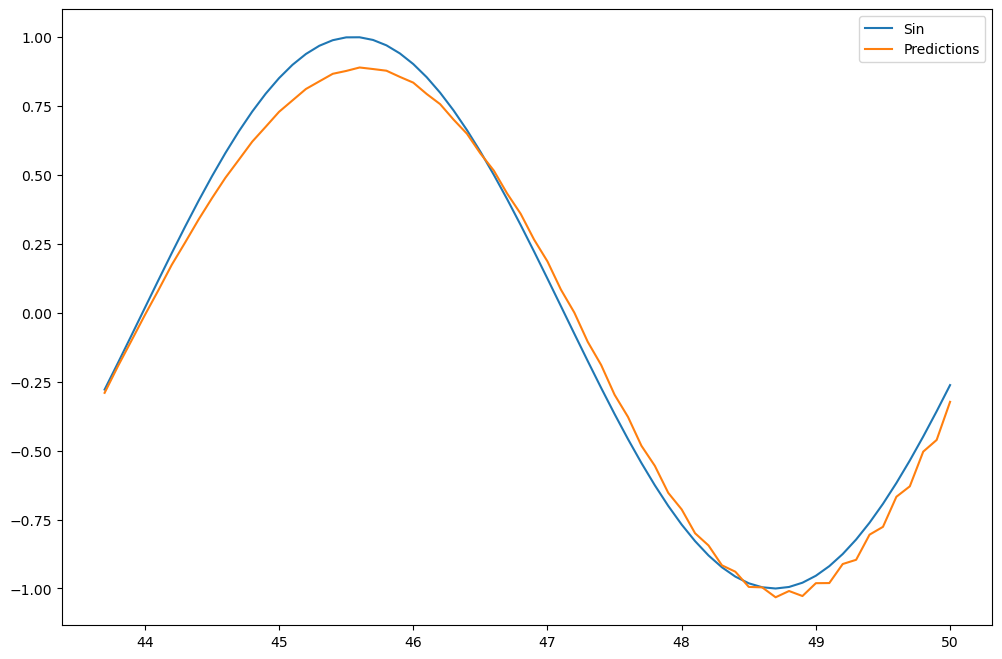

In [122]:
test.plot(figsize=(12,8))

In [123]:
# So as we can see, when we reached soomething somewhat similar

# Adding in Early Stopping and Validation Generator

In [125]:
from tensorflow.keras.callbacks import EarlyStopping

In [126]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [127]:
length = 50
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)


validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,batch_size=1)

### Now using LSTM

In [128]:
# define the model
model = Sequential()

# We're only using one feature in our time series
n_features = 1

# Simple RNN layer
model.add(LSTM(50,input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [129]:
model.fit(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
387/387 [==============================] - 9s 16ms/step - loss: 0.0166 - val_loss: 1.2855e-04
Epoch 2/20
387/387 [==============================] - 4s 11ms/step - loss: 2.3456e-04 - val_loss: 3.8585e-05
Epoch 3/20
387/387 [==============================] - 4s 10ms/step - loss: 1.2978e-04 - val_loss: 1.9226e-05
Epoch 4/20
387/387 [==============================] - 4s 10ms/step - loss: 3.7093e-04 - val_loss: 2.4276e-05
Epoch 5/20
387/387 [==============================] - 4s 10ms/step - loss: 1.4367e-04 - val_loss: 1.4945e-05
Epoch 6/20
387/387 [==============================] - 4s 10ms/step - loss: 1.4107e-04 - val_loss: 2.1314e-05
Epoch 7/20
387/387 [==============================] - 4s 10ms/step - loss: 1.5187e-04 - val_loss: 4.5108e-05


In [130]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    actual_prediction = model.predict(current_batch)
    #print(actual_prediction)
    test_predictions.append(actual_prediction[0])
    #print(test_predictions)
    #print([[[actual_prediction]])
    current_batch = np.append(current_batch[:,1:,:],[[actual_prediction[0]]],axis=1)
    

1/1 [==============================] - 0s 41ms/step


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_25008\2075574314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM Predictions'] = true_predictions


<Axes: >

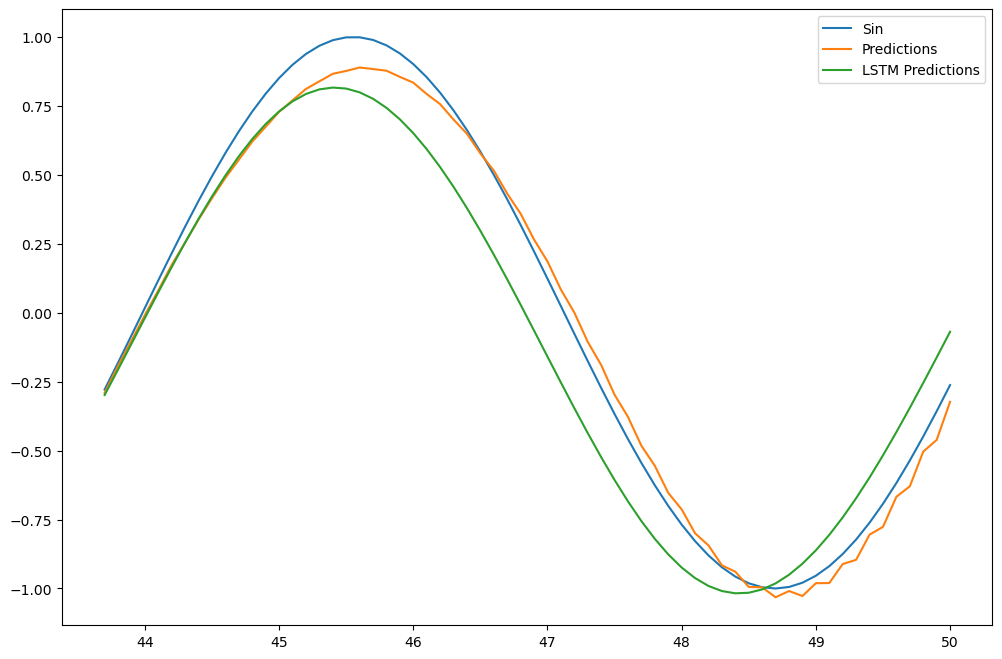

In [131]:
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

# Now we can forecast 

In [132]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [133]:
scaled_full_data

array([[4.99999116e-01],
       [5.49916225e-01],
       [5.99334579e-01],
       [6.47760405e-01],
       [6.94709850e-01],
       [7.39713809e-01],
       [7.82322618e-01],
       [8.22110545e-01],
       [8.58680040e-01],
       [8.91665714e-01],
       [9.20737985e-01],
       [9.45606372e-01],
       [9.66022399e-01],
       [9.81782075e-01],
       [9.92727935e-01],
       [9.98750612e-01],
       [9.99789928e-01],
       [9.95835500e-01],
       [9.86926839e-01],
       [9.73152957e-01],
       [9.54651478e-01],
       [9.31607263e-01],
       [9.04250562e-01],
       [8.72854714e-01],
       [8.37733417e-01],
       [7.99237589e-01],
       [7.57751870e-01],
       [7.13690771e-01],
       [6.67494535e-01],
       [6.19624741e-01],
       [5.70559686e-01],
       [5.20789614e-01],
       [4.70811810e-01],
       [4.21125636e-01],
       [3.72227539e-01],
       [3.24606094e-01],
       [2.78737119e-01],
       [2.35078919e-01],
       [1.94067715e-01],
       [1.56113277e-01],


In [134]:
length = 50 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [136]:
model = Sequential()
model.add(LSTM(50, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(generator,epochs=7)

Epoch 1/7
451/451 [==============================] - 9s 13ms/step - loss: 0.0132
Epoch 2/7
451/451 [==============================] - 5s 10ms/step - loss: 7.0646e-05
Epoch 3/7
451/451 [==============================] - 4s 9ms/step - loss: 1.6552e-04
Epoch 4/7
451/451 [==============================] - 4s 9ms/step - loss: 3.1959e-04
Epoch 5/7
451/451 [==============================] - 4s 9ms/step - loss: 1.4545e-04
Epoch 6/7
451/451 [==============================] - 4s 9ms/step - loss: 1.8767e-04
Epoch 7/7
451/451 [==============================] - 4s 10ms/step - loss: 2.8854e-05


In [137]:
test_predictions = []
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(50):
    actual_prediction = model.predict(current_batch)
    #print(actual_prediction)
    test_predictions.append(actual_prediction[0])
    #print(test_predictions)
    #print([[[actual_prediction]])
    current_batch = np.append(current_batch[:,1:,:],[[actual_prediction[0]]],axis=1)

1/1 [==============================] - 0s 28ms/step


In [138]:
forecast = scaler.inverse_transform(test_predictions)


In [139]:
df

,Sin
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [140]:
forecast

array([[-0.17887987],
       [-0.08196356],
       [ 0.01559446],
       [ 0.11293056],
       [ 0.20915148],
       [ 0.30333727],
       [ 0.3945562 ],
       [ 0.48187988],
       [ 0.56440232],
       [ 0.64125427],
       [ 0.71162294],
       [ 0.77476688],
       [ 0.83003163],
       [ 0.87686155],
       [ 0.91480818],
       [ 0.94353417],
       [ 0.96281827],
       [ 0.97254996],
       [ 0.97272627],
       [ 0.96344494],
       [ 0.94489494],
       [ 0.91734768],
       [ 0.88114804],
       [ 0.8367061 ],
       [ 0.78448844],
       [ 0.72501135],
       [ 0.65884012],
       [ 0.58658151],
       [ 0.50888319],
       [ 0.42643501],
       [ 0.33996701],
       [ 0.25024867],
       [ 0.15809121],
       [ 0.06434399],
       [-0.03010805],
       [-0.12434885],
       [-0.2174387 ],
       [-0.30842488],
       [-0.39635318],
       [-0.48028366],
       [-0.55930564],
       [-0.63255517],
       [-0.69923232],
       [-0.75861638],
       [-0.81007904],
       [-0

In [141]:
len(forecast)

50

In [142]:
x_forecast = np.arange(50.1,55.1,step=0.1)

In [143]:
df

,Sin
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


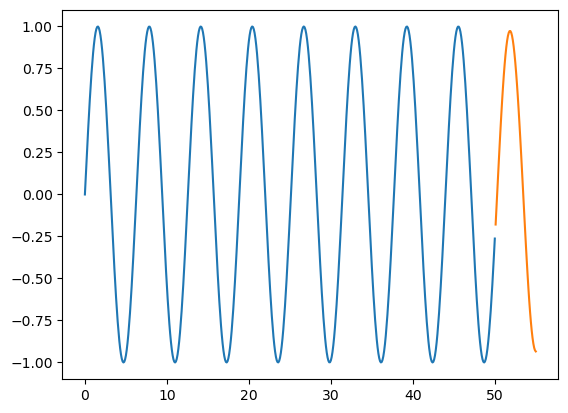

In [145]:
plt.plot(df.index,df['Sin'])
plt.plot(x_forecast,forecast)